In [1]:
import warnings
warnings.filterwarnings('ignore')

# import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim import corpora

from ast import literal_eval
from pickle import dump

from gensim.models.coherencemodel import CoherenceModel
#show graphs
import matplotlib.pyplot as plt

import pyLDAvis.gensim

In [9]:
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start):
    coherence_values = []
    for num_topics in range(start, limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=500)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return coherence_values

def make_corpus(data):
    #Make list of list
    mylist = []

    for i,j in data.iterrows():
        tmp = literal_eval(j.content)
        mylist.append(tmp)

    # Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
    bigram = Phrases(mylist, min_count=10)
    for idx in range(len(mylist)):
        for token in bigram[mylist[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                mylist[idx].append(token)

    # Create Dictionary
    dictionary = corpora.Dictionary(mylist)

    # Term Document Frequency
    corpus = [dictionary.doc2bow(text) for text in mylist]
    
    dump(corpus, open('corpus_LDA.pkl', 'wb'))
    dictionary.save('dictionary_LDA.gensim')
    
    return mylist,dictionary,corpus
    
def train(n_topic,corpus,dictionary):
    # Build LDA model
    lda_model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=n_topic, 
                        random_state=666)

    #Save Model
    lda_model.save('lda.h5')
    
    return lda_model

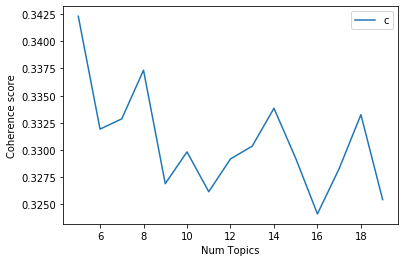

In [10]:
#Load Clean data
data = pd.read_csv('data_berita_clean.csv')

#Train
mylist,dictionary,corpus = make_corpus(data)

#search optimal topic number (5)
start=5
limit=20
coherence_values = compute_coherence_values(dictionary, corpus=corpus, 
                                                        texts=mylist, start=start, limit=limit)

x = range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
#Train
n_topic = 5
model = train(n_topic,corpus,dictionary)

In [5]:
# Print the Keyword in the 10 topics
topics = model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.011*"kuliah" + 0.009*"kerja" + 0.008*"ajar" + 0.007*"orang" + 0.007*"ilmu" + 0.006*"fakultas" + 0.005*"universitas" + 0.005*"mahasiswa" + 0.005*"guru" + 0.004*"sekolah"')
(1, '0.009*"mahasiswa" + 0.009*"teknik" + 0.009*"orang" + 0.008*"ilmu" + 0.007*"kuliah" + 0.007*"ajar" + 0.006*"universitas" + 0.006*"sobat" + 0.006*"kerja" + 0.005*"bahasa"')
(2, '0.016*"orang" + 0.013*"ajar" + 0.009*"kerja" + 0.007*"sobat" + 0.006*"universitas" + 0.006*"kuliah" + 0.005*"milik" + 0.005*"ilmu" + 0.005*"teknik" + 0.005*"pilih"')
(3, '0.009*"ajar" + 0.009*"didik" + 0.008*"universitas" + 0.007*"orang" + 0.006*"bahasa" + 0.005*"kuliah" + 0.005*"sekolah" + 0.005*"sobat" + 0.005*"mahasiswa" + 0.005*"ilmu"')
(4, '0.011*"orang" + 0.010*"ajar" + 0.008*"teknik" + 0.007*"kuliah" + 0.007*"universitas" + 0.007*"sobat" + 0.006*"kerja" + 0.006*"mahasiswa" + 0.005*"ilmu" + 0.005*"milik"')
(5, '0.009*"orang" + 0.008*"kuliah" + 0.008*"ajar" + 0.006*"sekolah" + 0.005*"mahasiswa" + 0.005*"teknik" + 0.005*"kerja" +

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.002479  0.009842       1        1  22.357121
3     -0.003092 -0.002137       2        1  21.605701
4      0.004684  0.014876       3        1  19.274065
2     -0.017029 -0.010092       4        1  19.237301
1      0.017916 -0.012489       5        1  17.525806, topic_info=     Category         Freq      Term        Total  loglift  logprob
919   Default   315.000000  beasiswa   315.000000  30.0000  30.0000
569   Default  2583.000000     orang  2583.000000  29.0000  29.0000
3290  Default   241.000000      laut   241.000000  28.0000  28.0000
133   Default   919.000000     didik   919.000000  27.0000  27.0000
7     Default   988.000000    bahasa   988.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
297    Topic5   102.032982      guru   728.189087  -0.2238  -5.9849
71     Topic5    91.360901       ptn   511.893311   0.0182  -6.0954
65     Topic5    97.146355     pilih   915.079590  -0.5013  -6.0340
462    Topic5    89.161667     hidup   501.265686   0.0148  -6.1197
488    Topic5    89.807167     lulus   620.357300  -0.1911  -6.1125

[449 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11360      1  0.695064         aba
6159       1  0.138469  agribisnis
6159       2  0.230782  agribisnis
6159       3  0.484643  agribisnis
6159       4  0.046156  agribisnis
...      ...       ...         ...
4083       2  0.561841           z
4083       3  0.109247           z
4083       4  0.171674           z
4083       5  0.078033           z
11567      1  0.699913     zoologi

[1191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])